# **1. Import Library**

In [ ]:
!pip install xgboost scikeras
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 28.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.13.0 requires scikit-learn>=1.4.2, but you have scikit-learn 1.3.1 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import torch
import tensorflow as tf
warnings.filterwarnings('ignore')
import collections
from scipy.stats import zscore
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight

from scikeras.wrappers import KerasClassifier, KerasRegressor
import xgboost as xgb

from tqdm.notebook import tqdm
tqdm.pandas()
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel, AutoConfig, pipeline
# pretrain='crypter70/IndoBERT-Sentiment-Analysis'
pretrain="w11wo/indonesian-roberta-base-sentiment-classifier"
# embedding model
tokenizer = AutoTokenizer.from_pretrained(pretrain)
config = AutoConfig.from_pretrained(pretrain)
model = AutoModel.from_pretrained(pretrain, config=config).to('cuda')

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/808k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/467k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at w11wo/indonesian-roberta-base-sentiment-classifier and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# **2. Data Retrieval**

In [ ]:
data=pd.read_csv('/content/bnpl dataset - original data labeled (optimized).csv')
data.head()

,content,factor_label,score
0,banyak spam telpon untuk promosi ajakan buka a...,AA,1
1,buruk ketika saya ingin membayar saya iklan se...,AE,1
2,saya menerima sms dari bank yang menyatakan ba...,AA,1
3,bank adalah yang terbaik sangat mudah digunakan,EU,5
4,selalu error jaringan saat foto ktp untuk akti...,AA,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4488 entries, 0 to 4487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   content       4488 non-null   object
 1   factor_label  4488 non-null   object
 2   score         4488 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 105.3+ KB


# **3. Exploratory Data Analysis**

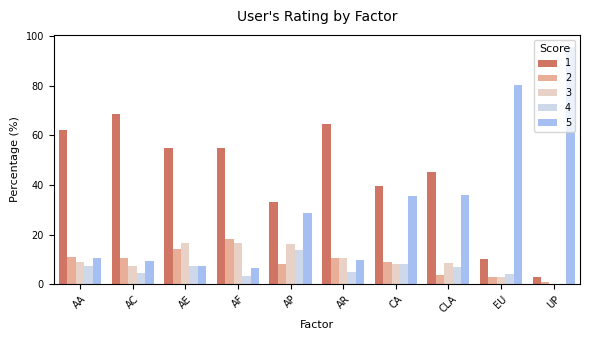

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate percentage directly within groupby
count_df = data.groupby(["factor_label", "score"]).size().reset_index(name="count")
count_df["percentage"] = count_df.groupby("factor_label")["count"].transform(lambda x: x / x.sum() * 100)

# Plot grouped bar chart
plt.figure(figsize=(6, 3.5))  # Smaller figure
sns.barplot(data=count_df, x="factor_label", y="percentage", hue="score", palette=sns.color_palette("coolwarm")[::-1])

# Optimize labels
plt.xlabel("Factor", fontsize=8)
plt.ylabel("Percentage (%)", fontsize=8)
plt.title("User's Rating by Factor", fontsize=10, pad=10)

# Reduce legend size
plt.legend(title="Score", fontsize=7, title_fontsize=8)

# Rotate x-axis labels for better fit
plt.xticks(rotation=45, fontsize=7)
plt.yticks(fontsize=7)

plt.tight_layout()  # Remove extra space
plt.show()


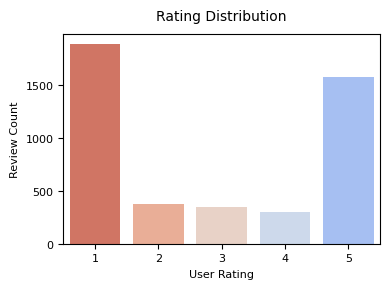

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a smaller figure size
plt.figure(figsize=(4, 3))  # Reduced size

sentiment_counts = data['score'].value_counts()
total = len(data)

# Use a compact color palette
palette = sns.color_palette("coolwarm", len(sentiment_counts))

ax = sns.countplot(x='score', data=data, palette=sns.color_palette("coolwarm")[::-1])

# Optimize labels and spacing
plt.title('Rating Distribution', fontsize=10, pad=10)  # Smaller title
plt.xlabel('User Rating', fontsize=8)
plt.ylabel('Review Count', fontsize=8)
plt.xticks(fontsize=8)  # Reduce tick font size
plt.yticks(fontsize=8)
plt.tight_layout()  # Remove extra padding

plt.show()


# **4. Classification Sentiment Analysis**

## **a. Feature Preparation**

In [ ]:
data.head()

,content,factor_label,score
0,banyak spam telpon untuk promosi ajakan buka a...,AA,1
1,buruk ketika saya ingin membayar saya iklan se...,AE,1
2,saya menerima sms dari bank yang menyatakan ba...,AA,1
3,bank adalah yang terbaik sangat mudah digunakan,EU,5
4,selalu error jaringan saat foto ktp untuk akti...,AA,1


In [ ]:
def bert_embedding(text):
    tokens = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=64).to('cuda')
    with torch.no_grad():
        outputs = model(**tokens)
    return outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()

In [ ]:
# Generate BERT embeddings
X = np.array([bert_embedding(text) for text in data["content"]])
y = data["score"]

In [ ]:
def prepare_data(X, y, test_size=0.3, stratify=y, random_state=42):
    return train_test_split(X, y, test_size=test_size, stratify=stratify, random_state=random_state)

In [ ]:
# Split data
X_train, X_test, y_train, y_test = prepare_data(X, y)

In [ ]:
def evaluate_model(model, y_pred, X_test, y_test):
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

## **b. Neural Network (NN)**

In [ ]:
num_features = 768 # BERT embedding dimension

def build_clf():
  # creating the layers of the NN
  ann = tf.keras.models.Sequential()
  ann.add(tf.keras.layers.Dense(units=128, activation='relu', input_shape=(num_features,))),
  ann.add(tf.keras.layers.Dense(units=64, activation='relu')),
  ann.add(tf.keras.layers.Dense(units=5, activation='softmax')),
  ann.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
  return ann

In [ ]:
ann = KerasClassifier(model=build_clf, epochs=50, verbose=0)

# Define Stratified K-Fold cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation and get accuracy scores
cv_scores = cross_val_score(ann, X_train, y_train, cv=kf)

# Train the model
ann.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32)

KerasClassifier(
	model=<function build_clf at 0x7d3310434e00>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
	class_weight=None
)

In [ ]:
ann_pred = ann.predict(X_test)

# Print results
print("===== ANN with Cross-Validation =====")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")
print("Test Set Accuracy:", accuracy_score(y_test, ann_pred))
print("F1:", f1_score(y_test, ann_pred, average='micro'))

print(classification_report(y_test, ann_pred))

===== ANN with Cross-Validation =====
Mean CV Accuracy: 0.6584
Standard Deviation: 0.0256
Test Set Accuracy: 0.6406829992576095
F1: 0.6406829992576095
              precision    recall  f1-score   support

           1       0.71      0.79      0.75       567
           2       0.13      0.11      0.12       113
           3       0.18      0.13      0.15       104
           4       0.20      0.12      0.15        89
           5       0.77      0.80      0.78       474

    accuracy                           0.64      1347
   macro avg       0.40      0.39      0.39      1347
weighted avg       0.61      0.64      0.62      1347



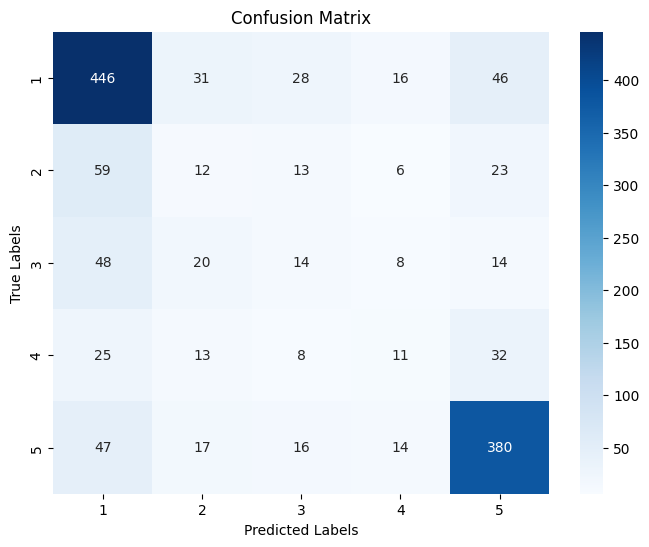

In [ ]:
evaluate_model(ann, ann_pred, X_test, y_test)

## **c. XGBoost (XGB)**

In [ ]:
from xgboost import XGBClassifier

# Define the XGBoost model
xgb = XGBClassifier(
    # max_depth=8,
    # reg_lambda=1,
    objective='multi:softmax',  # Predict class directly
    num_class=5,               # Number of classes
    n_estimators=80,
    learning_rate=0.01,
    tree_method='gpu_hist',    # Use GPU for faster training
    random_state=42
)

In [ ]:
# Define Stratified K-Fold cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation and get accuracy scores
cv_scores = cross_val_score(xgb, X_train, y_train-1, cv=kf)

# Fit the model
xgb.fit(X_train, y_train-1) # as XGBoost only support label from 0

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=80, n_jobs=None, num_class=5,
              num_parallel_tree=None, ...)

In [ ]:
xgb_pred = xgb.predict(X_test)

# Print results
print("===== XGB with Cross-Validation =====")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")
print("Test Set Accuracy:", accuracy_score(y_test-1, xgb_pred))
print("F1:", f1_score(y_test-1, xgb_pred, average='micro'))

print(classification_report(y_test-1, xgb_pred))

===== XGB with Cross-Validation =====
Mean CV Accuracy: 0.6883
Standard Deviation: 0.0157
Test Set Accuracy: 0.6755753526354863
F1: 0.6755753526354863
              precision    recall  f1-score   support

           0       0.64      0.91      0.75       567
           1       0.22      0.02      0.03       113
           2       0.15      0.03      0.05       104
           3       0.20      0.07      0.10        89
           4       0.80      0.81      0.81       474

    accuracy                           0.68      1347
   macro avg       0.40      0.37      0.35      1347
weighted avg       0.59      0.68      0.61      1347



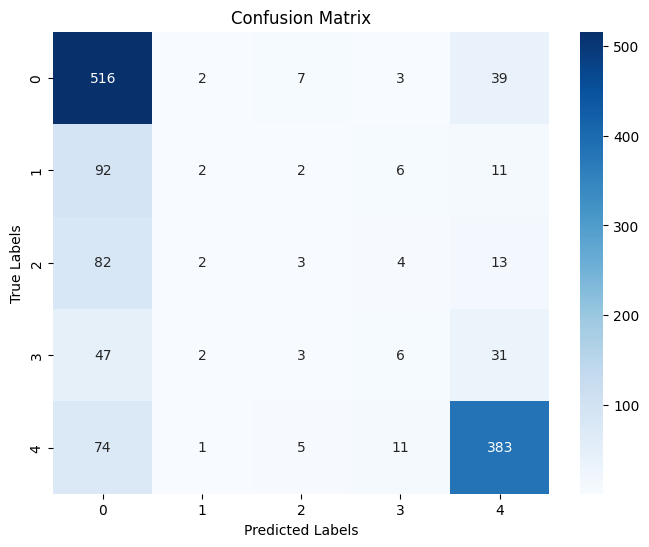

In [ ]:
evaluate_model(xgb,xgb_pred, X_test, y_test-1)

## **d. Random Forest (RF)**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(bootstrap=False, max_depth=7,
                            max_features='sqrt', min_samples_leaf=1,
                            min_samples_split=3, n_estimators=80,
                            random_state=42
                           )

In [ ]:
# Define Stratified K-Fold cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation and get accuracy scores
cv_scores = cross_val_score(rf, X_train, y_train, cv=kf)

# Fit the model
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=7, min_samples_split=3,
                       n_estimators=80, random_state=42)

In [ ]:
rf_pred = rf.predict(X_test)

# Print results
print("===== RF with Cross-Validation =====")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")
print("Test Set Accuracy:", accuracy_score(y_test, rf_pred))
print("F1:", f1_score(y_test, rf_pred, average='micro'))

print(classification_report(y_test, rf_pred))

===== RF with Cross-Validation =====
Mean CV Accuracy: 0.6877
Standard Deviation: 0.0122
Test Set Accuracy: 0.6867112100965108
F1: 0.6867112100965108
              precision    recall  f1-score   support

           1       0.63      0.93      0.75       567
           2       0.00      0.00      0.00       113
           3       0.00      0.00      0.00       104
           4       0.00      0.00      0.00        89
           5       0.78      0.84      0.81       474

    accuracy                           0.69      1347
   macro avg       0.28      0.35      0.31      1347
weighted avg       0.54      0.69      0.60      1347



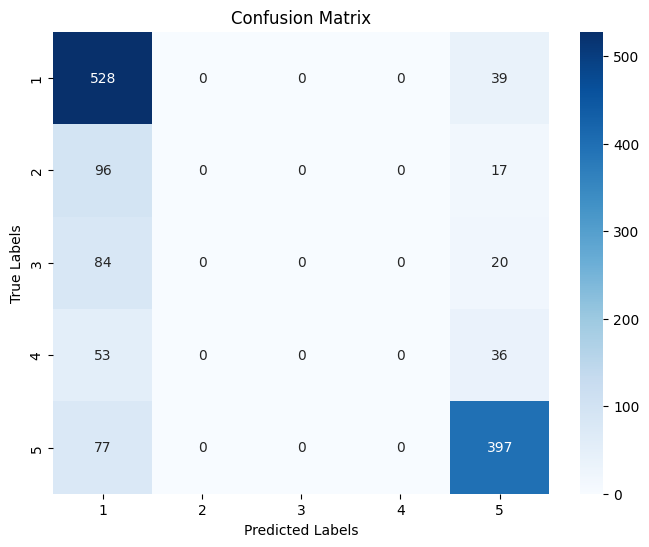

In [ ]:
evaluate_model(rf, rf_pred, X_test, y_test)

## **e. Support Vector Machine (SVM)**

In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', random_state=42)

In [ ]:
# Define Stratified K-Fold cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation and get accuracy scores
cv_scores = cross_val_score(svm, X_train, y_train, cv=kf)

# Fit the model
svm.fit(X_train, y_train)

SVC(random_state=42)

In [ ]:
svm_pred = svm.predict(X_test)

# Print results
print("===== SVM with Cross-Validation =====")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")
print("Test Set Accuracy:", accuracy_score(y_test, svm_pred))
print("F1:", f1_score(y_test, svm_pred, average='micro'))

print(classification_report(y_test, svm_pred))

===== SVM with Cross-Validation =====
Mean CV Accuracy: 0.6991
Standard Deviation: 0.0105
Test Set Accuracy: 0.6919079435783222
F1: 0.6919079435783222
              precision    recall  f1-score   support

           1       0.63      0.94      0.76       567
           2       0.00      0.00      0.00       113
           3       0.00      0.00      0.00       104
           4       0.00      0.00      0.00        89
           5       0.79      0.84      0.82       474

    accuracy                           0.69      1347
   macro avg       0.28      0.36      0.31      1347
weighted avg       0.54      0.69      0.61      1347



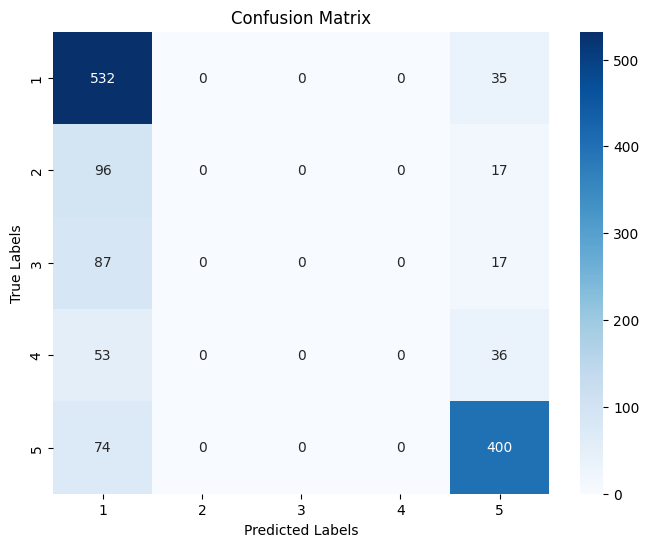

In [ ]:
evaluate_model(svm, svm_pred, X_test, y_test)

# **5. Predictive Sentiment Analysis**

## **a. Feature Preparation**

In [ ]:
data=pd.read_csv('/content/bnpl dataset - original data labeled (optimized).csv')
data.head()

,content,factor_label,score
0,banyak spam telpon untuk promosi ajakan buka a...,AA,1
1,buruk ketika saya ingin membayar saya iklan se...,AE,1
2,saya menerima sms dari bank yang menyatakan ba...,AA,1
3,bank adalah yang terbaik sangat mudah digunakan,EU,5
4,selalu error jaringan saat foto ktp untuk akti...,AA,1


In [ ]:
# One-hot encode factor_label
data = pd.get_dummies(data, columns=["factor_label"], prefix="factor")

onehot_columns = data.filter(like="factor_").columns
data[onehot_columns] = data[onehot_columns].astype(int)

X = data[onehot_columns]  # Selecting only the one-hot encoded columns
y = data["score"]

In [ ]:
X

,factor_AA,factor_AC,factor_AE,factor_AF,factor_AP,factor_AR,factor_CA,factor_CLA,factor_EU,factor_UP
0,1,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
4483,1,0,0,0,0,0,0,0,0,0
4484,0,0,0,0,0,0,0,0,1,0
4485,0,0,0,0,0,0,1,0,0,0
4486,0,0,0,0,0,0,1,0,0,0


In [ ]:
# Split data
X_train, X_test, y_train, y_test = prepare_data(X, y)

## **b. Neural Network (NN)**

In [ ]:
num_features = 10  # Update to 10 input features

def build_regressor():
    # Creating the layers of the regression model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=128, activation='relu', input_shape=(num_features,)))
    model.add(tf.keras.layers.Dense(units=64, activation='relu'))
    model.add(tf.keras.layers.Dense(units=1))  # Single neuron for regression output

    # Compile the model with a regression loss and metric
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    return model

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

ann = KerasRegressor(model=build_regressor, epochs=50, verbose=0)

# Train the model on the full training set
ann.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32)

KerasRegressor(
	model=<function build_regressor at 0x7924da1ebc40>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions
ann_pred = ann.predict(X_test)

# Evaluate regression model performance
mae = mean_absolute_error(y_test, ann_pred)
mse = mean_squared_error(y_test, ann_pred)
r2 = r2_score(y_test, ann_pred)

print(f"Test Set MAE: {mae:.4f}")
print(f"Test Set MSE: {mse:.4f}")
print(f"Test Set R² Score: {r2:.4f}")


Test Set MAE: 1.3394
Test Set MSE: 2.5008
Test Set R² Score: 0.2226


## **c. XGBoost (XGB)**

In [ ]:
from xgboost import XGBRegressor

# Define the XGBoost Regressor model
xgb = XGBRegressor(
    objective='reg:squarederror',  # Regression objective
    n_estimators=80,
    learning_rate=0.01,
    tree_method='gpu_hist',    # Use GPU for faster training
    random_state=42
)

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

# Fit the model
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=80, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Make predictions
xgb_pred = xgb.predict(X_test)

# Evaluate regression model performance
mae = mean_absolute_error(y_test, xgb_pred)
mse = mean_squared_error(y_test, xgb_pred)
r2 = r2_score(y_test, xgb_pred)

print(f"Test Set MAE: {mae:.4f}")
print(f"Test Set MSE: {mse:.4f}")
print(f"Test Set R² Score: {r2:.4f}")

Test Set MAE: 1.4878
Test Set MSE: 2.6134
Test Set R² Score: 0.1876


## **d. Random Forest (RF)**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Random Forest Regressor
rf = RandomForestRegressor(
    bootstrap=False,
    max_depth=7,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=3,
    n_estimators=80,
    random_state=42
)

In [ ]:
# Fit the model
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=7, max_features='sqrt',
                      min_samples_split=3, n_estimators=80, random_state=42)

In [ ]:
rf_pred = rf.predict(X_test)

# Evaluate regression model performance
mae = mean_absolute_error(y_test, rf_pred)
mse = mean_squared_error(y_test, rf_pred)
r2 = r2_score(y_test, rf_pred)

print(f"Test Set MAE: {mae:.4f}")
print(f"Test Set MSE: {mse:.4f}")
print(f"Test Set R² Score: {r2:.4f}")

Test Set MAE: 1.3509
Test Set MSE: 2.4802
Test Set R² Score: 0.2290


## **e. Support Vector Machine (SVM)**

In [ ]:
from sklearn.svm import SVR
svm = SVR(kernel='rbf')

In [ ]:
# Fit the model
svm.fit(X_train, y_train)

SVR()

In [ ]:
svm_pred = svm.predict(X_test)

# Evaluate regression model performance
mae = mean_absolute_error(y_test, svm_pred)
mse = mean_squared_error(y_test, svm_pred)
r2 = r2_score(y_test, svm_pred)

print(f"Test Set MAE: {mae:.4f}")
print(f"Test Set MSE: {mse:.4f}")
print(f"Test Set R² Score: {r2:.4f}")

Test Set MAE: 1.2563
Test Set MSE: 2.6903
Test Set R² Score: 0.1637


## **f. SHAP (SHapley Additive exPlanations)**

In [ ]:
!pip install shap

In [ ]:
# Create the SHAP explainer for the model
import shap
explainer = shap.TreeExplainer(rf)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

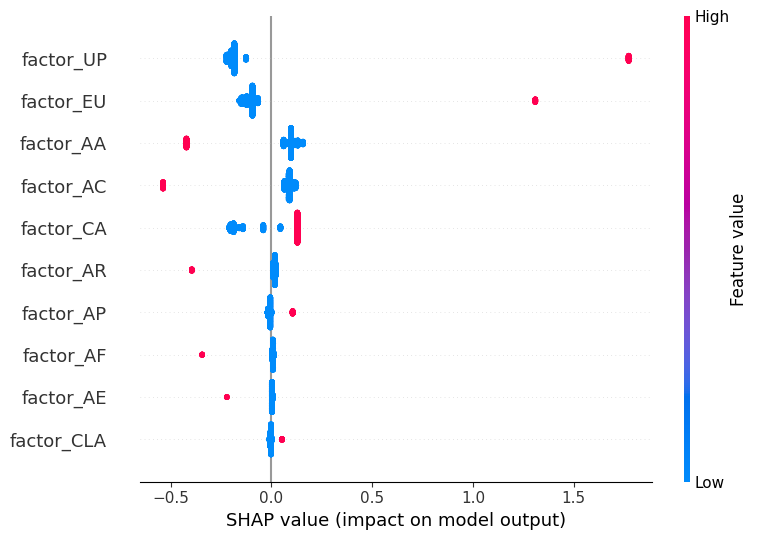

In [ ]:
shap.summary_plot(shap_values, X_test)

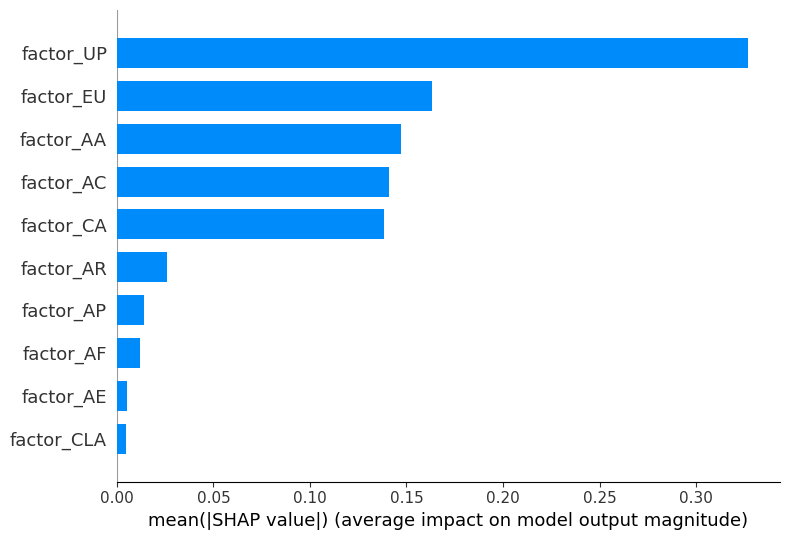

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type='bar')